/usr/lib/python3/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


conf
[[ 499  293]
 [ 894 1253]]
f1
[0.45675057 0.6785811 ]
roc
(array([0.        , 0.36994949, 1.        ]), array([0.        , 0.58360503, 1.        ]), array([2, 1, 0]))


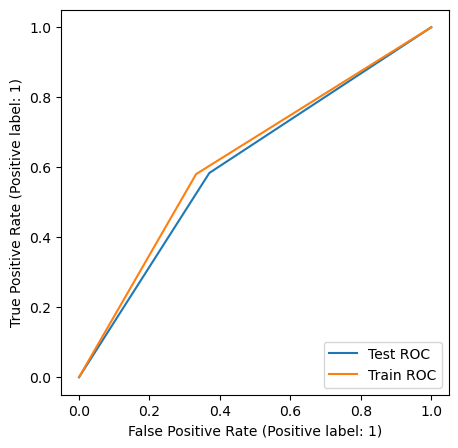

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
data_url = 'loan_applic.csv'  # Replace this with your dataset URL or local path
df = pd.read_csv(data_url)
df = df.drop(columns=['Application Number','crime_record','Application: BPA Broker Negotiation','Application: Close Date'])
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
from datetime import datetime
#df['Application: Close Date'] = df['Application: Close Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y").timestamp())
df['Yearly Total Sales'] = pd.to_numeric(df['Yearly Total Sales'].str.replace(',', '')) # a lot
df['Application: Remittance Frequency'] = df['Application: Remittance Frequency'].str.replace('Daily', '1.0109345606271172')
df['Application: Remittance Frequency'] = df['Application: Remittance Frequency'].str.replace('Weekly', '-0.4274440148269396')
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
object_cols = df.select_dtypes(include='object').columns.tolist()

for col in object_cols:
    df[col] = df[col].fillna('Missing')
    
for col in numeric_columns:
    mean_value = df[col].mean() # TODO check other possibilities
    df[col] = df[col].fillna(mean_value)

y = df['Outcome']
X = df.drop(columns=['Outcome'])

# at this point we don't have NaNs
# number column have type number
# string column have type string

tmp = X[numeric_columns]
pearson_corr = tmp.corr(method='pearson')
spearman_corr = tmp.corr(method='spearman')
threshold = 0.8  # You can adjust this threshold as needed
high_corr_pairs = []
for i in range(len(pearson_corr.columns)):
    for j in range(i):
        if abs(pearson_corr.iloc[i, j]) > threshold:
            high_corr_pairs.append((pearson_corr.columns[i], pearson_corr.columns[j], pearson_corr.iloc[i, j]))
for i in range(len(spearman_corr.columns)):
    for j in range(i):
        if abs(spearman_corr.iloc[i, j]) > threshold:
            high_corr_pairs.append((spearman_corr.columns[i], spearman_corr.columns[j], spearman_corr.iloc[i, j]))
features_to_remove = set()
for pair in high_corr_pairs:
    features_to_remove.add(pair[0])  # Add first feature from pair
    features_to_remove.add(pair[1])  # Add second feature from pair
X = X.drop(columns=features_to_remove)

lol_x = X.copy(deep=True)


object_cols = X.select_dtypes(include='object').columns.tolist()
label_encoder = {}
for col in object_cols:
    label_encoder[col] = LabelEncoder()
    X[col] = label_encoder[col].fit_transform(X[col].astype(str))
label_encoder['y'] = LabelEncoder()
y = label_encoder['y'].fit_transform(y.astype(str))



X=pd.DataFrame(X)
y=pd.DataFrame(y)
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state=0)
for train_index, test_index in sss.split(X,y):
    X_train, X_test = X.loc[train_index],X.loc[test_index] # error if we don't do StandardScaler before
    y_train, y_test = y.loc[train_index],y.loc[test_index]
    
if True:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


from sklearn.linear_model import LogisticRegression
stack_clf = LogisticRegression()
stack_clf.fit(X_train, y_train)
predictions = stack_clf.predict(X_test)
predictions_train = stack_clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
data_url = 'loan_applic.csv'  # Replace this with your dataset URL or local path
df = pd.read_csv(data_url)
df = df.drop(columns=['Application Number','crime_record','Application: BPA Broker Negotiation'])
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
from datetime import datetime
df['Application: Close Date'] = df['Application: Close Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y").timestamp())
df['Yearly Total Sales'] = pd.to_numeric(df['Yearly Total Sales'].str.replace(',', '')) # a lot
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
object_cols = df.select_dtypes(include='object').columns.tolist()

for col in object_cols:
    df[col] = df[col].fillna('Missing')
    
for col in numeric_columns:
    mean_value = df[col].mean() # TODO check other possibilities
    df[col] = df[col].fillna(mean_value)

In [14]:
df

,Application: Buy Rate,Application: Funded Amount,Application: Origination Fee,Application: Remittance Frequency,Primary Contact Gender,Application: Close Date,customer Age,Amount,Applications received All Time,Applications received by last 1 Month,Applications received by last 3 Months,Applications received by last 6 Months,Average Daily Negatives,Average Monthly Sales,Avg Daily Bank Balance,Avg Number of Monthly Deposits,Brokers submitted All Time,Brokers submitted last 1 month,Brokers submitted last 3 months,Brokers submitted last 6 months,Credit Score,Daily Bank Balance v/s Daily Payment,Days,Factor Rate,Has Website,Industry,Inquiry Count,Months,Number of Trade Lines,Office Space,Open Bankruptcy,Position,Public Records,Sales to Payment,Satisfactory,Shipping State,Sum of Monthly Personal Debt,Time In Business Actual,Type,Volume - 4 Months Ago,Volume - 6 Months Ago,Volume - Three Months Ago,Yearly Total Sales,Outcome
0,1.250,9000.0,2.0,Daily,Missing,1.483402e+09,35.0,9000.0,1.0,1.0,1.0,1.0,0.00,10724.06,2824.15,3.33,1.0,1.0,1.0,1.0,741.0,30.9225,135.0,1.370,Yes,Healthcare,24.0,6.43,40.0,Rent,0.0,First,0.0,18.00,40.0,NJ,4792.0,24.0,New Deal,0.00000,0.000000,1.160573e+04,128688.72,Neg
1,1.250,9500.0,2.0,Daily,Male,1.483402e+09,47.0,9500.0,2.0,2.0,2.0,2.0,0.25,29319.24,2401.76,36.50,1.0,1.0,1.0,1.0,624.0,24.7196,132.0,1.350,Yes,Dentists,18.0,6.29,25.0,Rent,0.0,Second,0.0,18.00,24.0,OH,2867.0,17.7,New Deal,35205.42000,29288.310000,3.020932e+04,351830.88,Neg
2,1.250,6000.0,2.0,Daily,Male,1.483402e+09,58.0,6000.0,4.0,1.0,3.0,4.0,0.67,11009.45,606.48,46.67,3.0,1.0,2.0,3.0,590.0,10.1844,132.0,1.310,No,Retail,51.0,6.29,20.0,Rent,0.0,Second,0.0,6.50,15.0,NY,1331.0,17.5,New Deal,6299.58000,4799.650000,9.281730e+03,132113.40,Neg
3,1.250,15000.0,2.0,Daily,Male,1.483402e+09,62.0,15000.0,1.0,1.0,1.0,1.0,0.67,37346.40,1737.83,53.33,1.0,1.0,1.0,1.0,650.0,11.3280,132.0,1.350,Yes,Spa/Salon,1.0,6.29,24.0,Own,0.0,First,3.0,0.00,8.0,MN,16491.0,5.1,New Deal,0.00000,0.000000,4.411452e+04,448156.80,Pos
4,1.250,14000.0,2.0,Daily,Female,1.483402e+09,64.0,14000.0,1.0,1.0,1.0,1.0,0.67,17122.11,2194.66,7.00,1.0,1.0,1.0,1.0,504.0,15.1043,132.0,1.370,Yes,Contracting,13.0,6.29,24.0,Rent,0.0,First,0.0,0.00,22.0,PA,1373.0,1.5,New Deal,0.00000,0.000000,1.616817e+04,205465.32,Pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9790,1.270,200000.0,3.0,Daily,Male,1.546214e+09,51.0,200000.0,7.0,1.0,2.0,3.0,0.82,409443.13,81764.80,6.55,1.0,1.0,1.0,1.0,741.0,55.0047,176.0,1.330,Yes,Law Offices,4.0,8.38,29.0,Rent,0.0,First,0.0,0.00,28.0,TX,2400.0,19.8,Paid Renewal,103698.18769,99705.173486,1.522674e+05,4913317.56,Pos
9791,1.280,250000.0,3.0,Daily,Male,1.546214e+09,54.0,250000.0,2.0,2.0,2.0,2.0,4.00,905543.09,121173.15,22.00,1.0,1.0,1.0,1.0,728.0,91.1508,252.0,1.340,Yes,Wholesale,12.0,12.00,16.0,Own,0.0,First,0.0,0.00,15.0,LA,7184.0,28.0,Potential Dupe,103698.18769,99705.173486,1.034012e+06,10866517.08,Pos
9792,1.310,36000.0,3.0,Daily,Male,1.546214e+09,46.0,36000.0,6.0,1.0,1.0,1.0,0.33,42262.39,6487.52,51.33,2.0,1.0,1.0,1.0,726.0,18.1586,132.0,1.310,Yes,Wholesale,0.0,6.29,15.0,Rent,0.0,First,0.0,0.00,15.0,PA,1865.0,5.6,Paid Renewal,103698.18769,99705.173486,9.754718e+04,507148.68,Pos
9793,1.375,125000.0,3.0,Daily,Male,1.546214e+09,54.0,125000.0,1.0,1.0,1.0,1.0,1.00,176505.99,10906.83,20.00,1.0,1.0,1.0,1.0,642.0,8.9881,154.0,1.495,Yes,Contracting,18.0,7.33,17.0,Rent,1.0,First,1.0,0.00,13.0,CA,5138.0,18.6,New Deal,207219.75000,99705.173486,1.349221e+05,2118071.88,Pos


In [16]:
df['Application: Remittance Frequency'].value_counts()

Daily     9719
Weekly      76
Name: Application: Remittance Frequency, dtype: int64

In [17]:
df['Outcome']

0       Neg
1       Neg
2       Neg
3       Pos
4       Pos
       ... 
9790    Pos
9791    Pos
9792    Pos
9793    Pos
9794    Pos
Name: Outcome, Length: 9795, dtype: object

In [25]:
df[df['Application: Remittance Frequency'] == 'Daily']['Outcome'].value_counts()

Pos    7126
Neg    2593
Name: Outcome, dtype: int64

In [29]:
daily_pos = 7126/(7126+2593)
daily_pos

0.7332030044243235

In [31]:
np.log(daily_pos/(1-daily_pos))

1.0109345606271172

In [28]:
df[df['Application: Remittance Frequency'] == 'Weekly']['Outcome'].value_counts()

Neg    46
Pos    30
Name: Outcome, dtype: int64

In [30]:
weekly_pos = 30/(30+46)
weekly_pos

0.39473684210526316

In [32]:
np.log(weekly_pos/(1-weekly_pos))

-0.4274440148269396

In [34]:
df['Application: Remittance Frequency'] = df['Application: Remittance Frequency'].str.replace('Daily', '1.0109345606271172')

In [36]:
df['Application: Remittance Frequency'] = df['Application: Remittance Frequency'].str.replace('Daily', '1.0109345606271172')
df['Application: Remittance Frequency'] = df['Application: Remittance Frequency'].str.replace('Weekly', '-0.4274440148269396')

In [38]:
df['Application: Remittance Frequency'].value_counts()

1.0109345606271172     9719
-0.4274440148269396      76
Name: Application: Remittance Frequency, dtype: int64

In [38]:
me = lol_x.head(n=1).copy(deep=True)
me['customer Age'] = 1111
for col in object_cols:
    me[col] = label_encoder[col].transform(me[col].astype(str))
me = scaler.transform(me)
stack_clf.predict(me)

array([1])

In [39]:
label_encoder['y'].transform(['Pos'])

array([1])

In [40]:
stack_clf.coef_[0]

array([-0.00836853, -0.11541996, -0.22400637, -0.43797846,  0.11832074,
        0.01283551,  0.01362226,  0.10719436,  0.13916461,  0.13437005,
        0.04404126, -0.04287798, -0.13989176, -0.11452851, -0.02647684,
        0.02343132,  0.06033156, -0.04272456,  0.04158958, -0.0228201 ,
        0.2171173 ,  0.20415172])

In [41]:
lol_x.columns

Index(['Application: Origination Fee', 'Application: Remittance Frequency',
       'Primary Contact Gender', 'Application: Close Date', 'customer Age',
       'Average Daily Negatives', 'Avg Daily Bank Balance',
       'Avg Number of Monthly Deposits', 'Credit Score',
       'Daily Bank Balance v/s Daily Payment', 'Has Website', 'Industry',
       'Inquiry Count', 'Office Space', 'Open Bankruptcy', 'Position',
       'Public Records', 'Sales to Payment', 'Shipping State',
       'Sum of Monthly Personal Debt', 'Time In Business Actual', 'Type'],
      dtype='object')

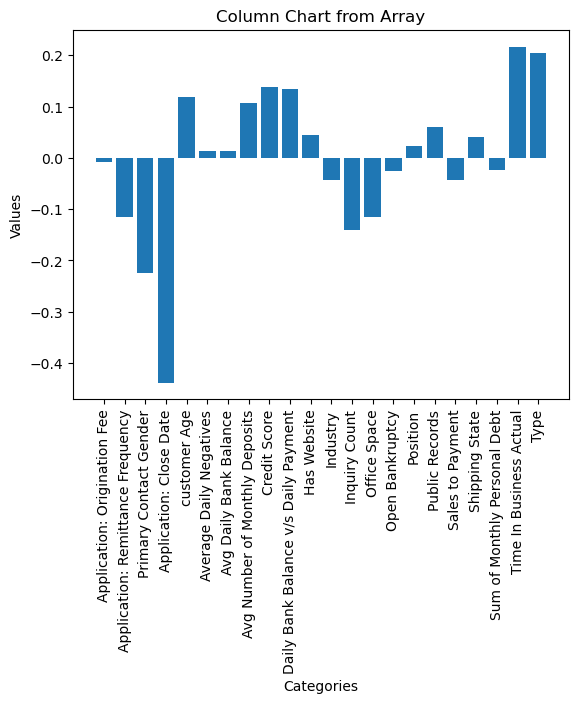

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (array)
categories = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
values = np.array([1.00445066, -11.05223103, 1, 2])

# Create a bar chart
plt.bar(lol_x.columns, stack_clf.coef_[0])

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Column Chart from Array')
plt.xticks(rotation='vertical')

# Display the plot
plt.show()

/usr/lib/python3/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


conf
[[ 463  329]
 [ 776 1371]]
f1
[0.45593304 0.71276319]
roc
(array([0.        , 0.41540404, 1.        ]), array([0.        , 0.63856544, 1.        ]), array([2, 1, 0]))


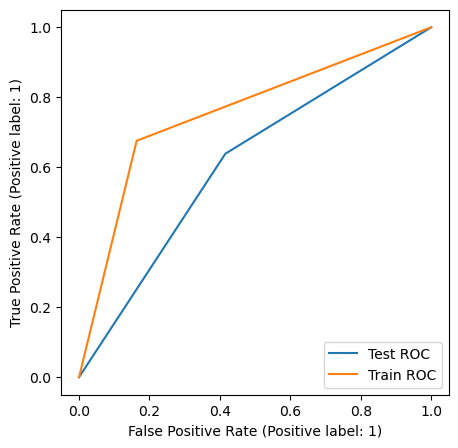

In [8]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
stack_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
stack_clf.fit(X_train, y_train)
predictions = stack_clf.predict(X_test)
predictions_train = stack_clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

/usr/lib/python3/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


conf
[[ 472  320]
 [ 802 1345]]
f1
[0.45692159 0.70566632]
roc
(array([0.       , 0.4040404, 1.       ]), array([0.        , 0.62645552, 1.        ]), array([2, 1, 0]))


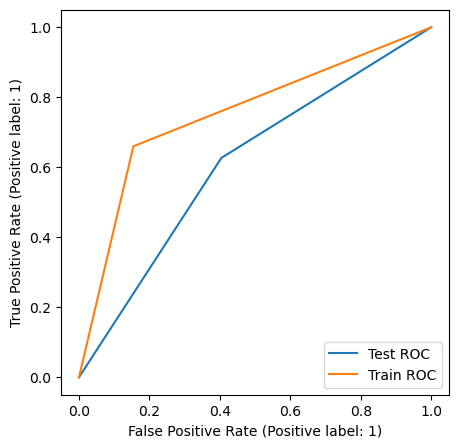

In [9]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
stack_clf = BaggingClassifier(estimator=SVC(),
                        n_estimators=10, random_state=0)
stack_clf.fit(X_train, y_train)
predictions = stack_clf.predict(X_test)
predictions_train = stack_clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

/usr/lib/python3/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/lib/python3/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


conf
[[ 452  340]
 [ 739 1408]]
f1
[0.45587494 0.72297818]
roc
(array([0.        , 0.42929293, 1.        ]), array([0.        , 0.65579879, 1.        ]), array([2, 1, 0]))


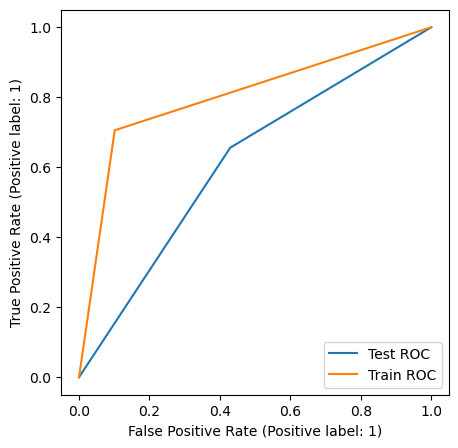

In [11]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()#lolodlsaolodalsoloasdl
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
clf4 = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
####################################
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
clf5 = MLPClassifier(random_state=1, max_iter=300)
####################################

stack_clf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3),('dasdas',clf4),('dasasdasddsa',clf5)],
    voting='hard')

stack_clf.fit(X_train, y_train)
predictions = stack_clf.predict(X_test)
predictions_train = stack_clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

conf
[[ 480  312]
 [ 798 1349]]
f1
[0.46376812 0.7085084 ]
roc
(array([0.        , 0.39393939, 1.        ]), array([0.        , 0.62831858, 1.        ]), array([2, 1, 0]))


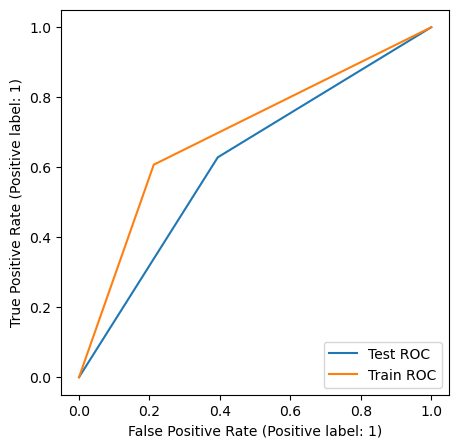

In [8]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
parameters = {
    'max_depth':(2,3,4,5,6),
    'min_samples_split':(2,3,4,5,6),
    #'kernel':('linear', 'rbf'),
    #'C':[1, 10],
}
stack_clf = GridSearchCV(DecisionTreeClassifier(), parameters)

stack_clf.fit(X_train, y_train)
predictions = stack_clf.predict(X_test)
predictions_train = stack_clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

/usr/lib/python3/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/lib/python3/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iteration

conf
[[ 304  488]
 [ 407 1740]]
f1
[0.40452428 0.79542857]
roc
(array([0.        , 0.61616162, 1.        ]), array([0.        , 0.81043316, 1.        ]), array([2, 1, 0]))


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


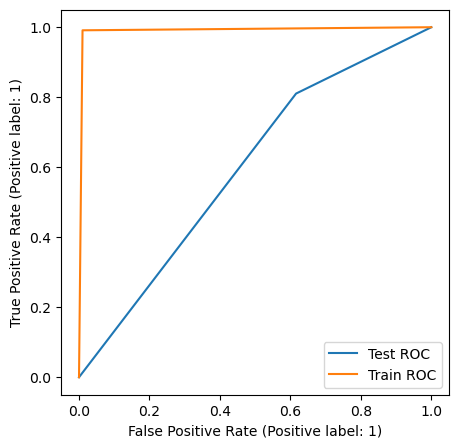

In [12]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVC( random_state=42)))
]
stack_clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

stack_clf.fit(X_train, y_train)
predictions = stack_clf.predict(X_test)
predictions_train = stack_clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

In [49]:
from sklearn.ensemble import RandomForestClassifier
stack_clf = RandomForestClassifier(max_depth=2, random_state=0)
X_train = X_train.drop('Application: Close Date')
X_test = X_test.drop('Application: Close Date')
stack_clf.fit(X_train, y_train)
predictions = stack_clf.predict(X_test)
predictions_train = stack_clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

In [47]:
stack_clf.feature_importances_

array([0.16786572, 0.00122473, 0.02148367, 0.2418897 , 0.00372113,
       0.07049479, 0.00567317, 0.0134726 , 0.01307271, 0.11692094,
       0.01064401, 0.00572329, 0.05330571, 0.00043546, 0.        ,
       0.        , 0.00470382, 0.04328953, 0.00776097, 0.00414239,
       0.12656522, 0.08761046])

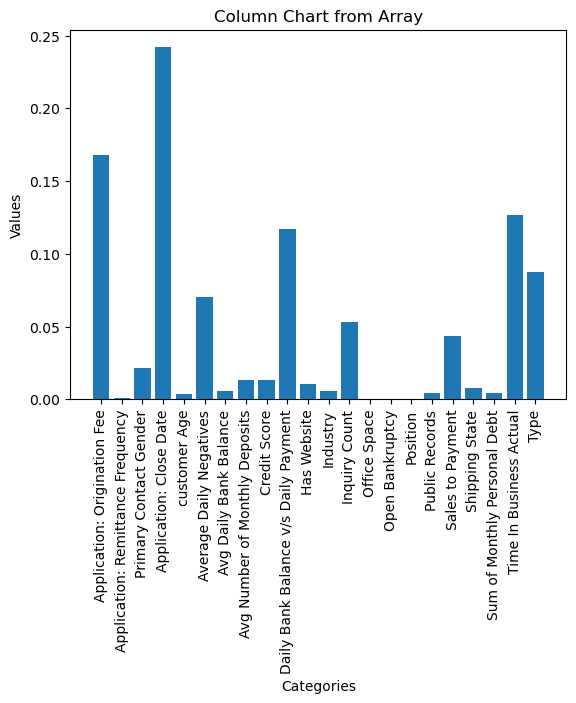

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (array)
categories = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
values = np.array([1.00445066, -11.05223103, 1, 2])

# Create a bar chart
plt.bar(lol_x.columns, stack_clf.feature_importances_)

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Column Chart from Array')
plt.xticks(rotation='vertical')

# Display the plot
plt.show()